In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import f1_score

# Module to save and load Python objects to and from files
import pickle  

# NOTE notebook is based closely off prevous notebooks for decision tree and random forest models from previous labs/assignments

In [9]:
# Import Data
df = pd.read_csv('framingham.csv')
df = df.dropna()
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [10]:
# Select input and output features
X = df.drop(columns = ['TenYearCHD'])
y = df['TenYearCHD']
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
# models
rf_clf = RandomForestClassifier(random_state = 42)
dt_clf = DecisionTreeClassifier(random_state = 42)
Ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)

In [12]:
# get f1 scores and assign weights
    # NOTE the idea of looping through the models was from ChatGPT
f1_scores = {}
for clf in (rf_clf, dt_clf, Ada_clf):
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    f1 = f1_score(test_y, pred_y, average='macro')
    f1_scores[clf.__class__.__name__] = f1
    print(f"{clf.__class__.__name__} F1-macro Score: {f1:.4f}")

weights = np.array(list(f1_scores.values()))
weights = weights / weights.sum()
print("Weights (normalized to 1):", weights)



RandomForestClassifier F1-macro Score: 0.5012
DecisionTreeClassifier F1-macro Score: 0.5176


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier F1-macro Score: 0.5923
Weights (normalized to 1): [0.31106756 0.32128553 0.36764691]


In [13]:
# Soft Voting Classifier
softVote_clf = VotingClassifier(estimators=[('rf', rf_clf), ('dt', dt_clf), ('adb', Ada_clf)], voting='soft', weights=weights)
softVote_clf.fit(train_X, train_y)

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('adb',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=0))],
                 voting='soft',
                 weights=array([0.31106756, 0.32128553, 0.36764691]))

In [14]:
# NOTE loop structure (zip, hasattr) & indexing help from ChatGPT

feature_importance = {}
for clf_name, clf in zip(f1_scores.keys(), [rf_clf, dt_clf, Ada_clf]):
    if hasattr(clf, 'feature_importances_'):
        feature_importance[clf_name] = clf.feature_importances_
    else:
        feature_importance[clf_name] = np.zeros(X.shape[1])

combined_feature_importance = np.zeros(X.shape[1])
for i, clf_name in enumerate(f1_scores.keys()):
    combined_feature_importance += weights[i] * feature_importance[clf_name]    

combined_feature_importanceDisplay = pd.Series(combined_feature_importance, index=X.columns).sort_values(ascending=False)
print(combined_feature_importanceDisplay)



BMI                0.185941
sysBP              0.145938
glucose            0.128142
age                0.122716
diaBP              0.111789
totChol            0.102832
heartRate          0.079200
cigsPerDay         0.046705
education          0.031584
male               0.016544
prevalentHyp       0.009002
prevalentStroke    0.006633
BPMeds             0.005314
currentSmoker      0.005055
diabetes           0.002605
dtype: float64


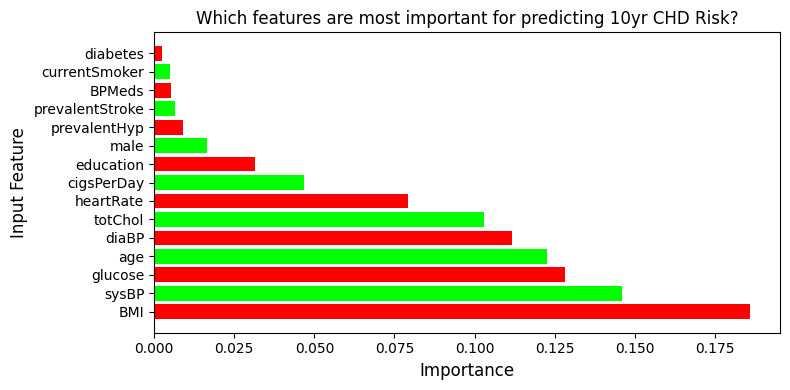

In [15]:
# Storing importance values from the trained model
importance = combined_feature_importance

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are most important for predicting 10yr CHD Risk?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();
# save feature importance
plt.savefig("feature_imp_SV.svg", bbox_inches = 'tight')

In [ ]:
# for clf in (rf_clf, dt_clf, Ada_clf, softVote_clf):
#     clf.fit(train_X, train_y)
#     pred_y = clf.predict(test_X)
#     f1 = f1_score(test_y, pred_y, average='weighted')
#     print(f"{clf.__class__.__name__} F1 Score: {f1:.4f}")

    

## **Confusion Matrix**


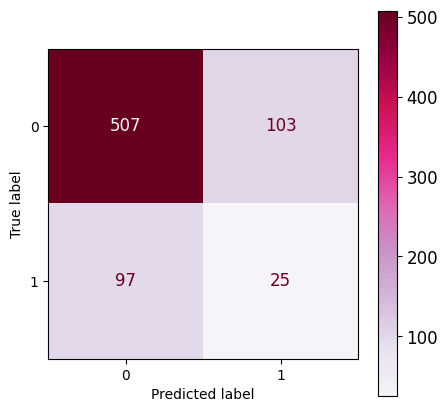

In [16]:
# Predictions on test set
y_pred = softVote_clf.predict(test_X)

# Now generate confusion matrix
cm = confusion_matrix(test_y, y_pred, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

# Specify figure size
fig, ax = plt.subplots(figsize = (5, 5))
plt.rcParams.update({'font.size': 12})

# Display Confusion Matrix
disp.plot(cmap = 'PuRd', ax = ax)

# Save as SVG
plt.savefig("confusionMat_sv.svg", bbox_inches = 'tight');

## **Save Model**

In [17]:
sv_pickle = open('SoftVote_chd.pickle', 'wb') 

# Write DT model to the file
pickle.dump(softVote_clf, sv_pickle) 

# Close the file
sv_pickle.close() 
